In [138]:
!pip install neattext
!pip install wordcloud
!pip install nltk

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
from nltk.corpus import stopwords


import neattext as nt

In [140]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [141]:
print('Train data shape:', train_df.shape)
print('Train columns:', train_df.columns)
print('Test data shape:', test_df.shape)
print('Test columns:', test_df.columns)

Train data shape: (7613, 5)
Train columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Test data shape: (3263, 4)
Test columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [142]:
train_df = train_df.drop(['id'], axis = 1)
test_df = test_df.drop(['id'], axis = 1)
#df = df.drop(['id'], axis = 1)

In [143]:
print('Number of duplicated text on train data: ',train_df.duplicated(['text']).sum())
print('Number of duplicated text on test data: ',test_df.duplicated(['text']).sum())

Number of duplicated text on train data:  110
Number of duplicated text on test data:  20


In [144]:
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,keyword,location,text,target
4299,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...
3461,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,sinking,MA,that horrible sinking feeling when youÛªve be...,1


In [145]:
s = train_df.groupby('text').target.agg(lambda x : x.mode()[0])
drop_dup = pd.DataFrame({'text':s.index, 'target':s.values})
train_df = train_df.drop_duplicates(subset=['text'])


#train_df.loc[train_df.text.isin(drop_dup.text), ['target']] = drop_dup[['target']]
#train_df

In [146]:
test_df = test_df.drop_duplicates(subset=['text'])
test_df

,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
3258,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [147]:
def missing_ratio(_df):
    missing_cols = _df.columns[_df.isnull().any()]
    plt.subplots(figsize=(6, 6))
    missing_ratio = _df[missing_cols].isnull().sum() * 100 / len(_df)
    missing_ratio.sort_values(inplace=True)
    missing_ratio.plot.bar(missing_ratio)
    return missing_ratio

keyword      0.746368
location    33.080101
dtype: float64

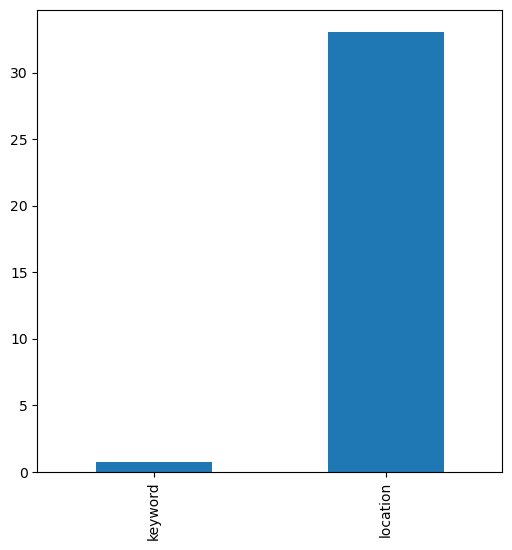

In [148]:
train_missing = missing_ratio(train_df)
train_missing

keyword      0.801727
location    33.826704
dtype: float64

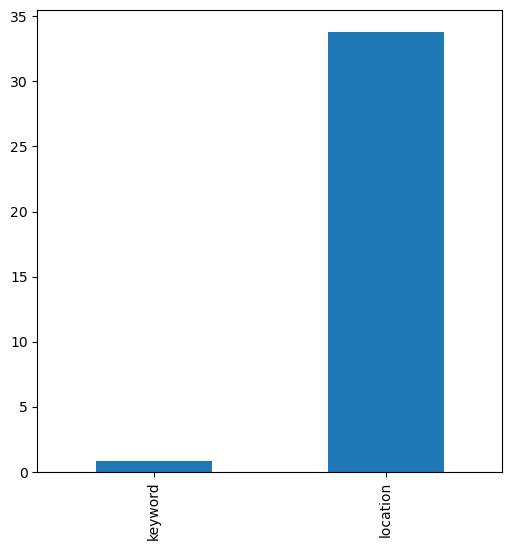

In [149]:
test_missing = missing_ratio(test_df)
test_missing

In [150]:
def clean_text(text):
    docx = nt.TextFrame(text=text)
    docx.normalize(level='deep')
    docx.remove_puncts()
    docx.remove_urls()
    docx.remove_special_characters()
    docx.remove_emojis()
    docx.fix_contractions()
    return docx.text
    # Chuyển sang viết thường hết
    # Remove email, mention
    #Thêm reomvoe stopwwrd 

In [151]:
train_df['text']=train_df['text'].apply(lambda x: clean_text(x))
test_df['text']=test_df['text'].apply(lambda x: clean_text(x))

In [152]:
train_df['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7604    WorldNews Fallen powerlines on Glink tram UPDA...
7605    on the flip side Im at Walmart and there is a ...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7503, dtype: object

In [153]:
test_df['text']

0                      Just happened a terrible car crash
1       Heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   Apocalypse lighting Spokane wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES  SAFETY FASTENER...
3259    Storm in RI worse than last hurricane My citya...
3260    Green Line derailment in Chicago httptcoUtbXLc...
3261    MEG issues Hazardous Weather Outlook HWO httpt...
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 3243, dtype: object

## Khám phá dữ liệu

In [154]:
count_target = train_df.groupby("target").count()
count_target = count_target.rename(columns={"text": "count"})
fig = px.bar(count_target, x=count_target.index, y='count')
fig.update_layout(xaxis={'type': 'category'}, title={
            'text': 'Phân bố cột target',
            'x': 0.5,  # Giữa trục x
            'xanchor': 'center',  # Căn giữa theo trục x
            'yanchor': 'top'  # Căn theo trục y
        })
fig.show()

In [155]:
top_key_word = train_df.groupby(["keyword"])["target"].mean().reset_index().sort_values(by = 'target', ascending=False)
top_key_word = pd.concat([top_key_word.head(10), top_key_word.tail(10)])
top_key_word = top_key_word["keyword"]

target_by_keyword = train_df.groupby(["keyword", "target"])["text"].count().reset_index()
target_by_keyword = target_by_keyword.rename(columns={"text": "count"})
target_by_keyword = target_by_keyword[target_by_keyword["keyword"].isin(top_key_word)]
target_by_keyword = target_by_keyword.sort_values(by=["target", "count"], ascending=[True, False])
target_by_keyword['target'] = target_by_keyword['target'].astype(object)
fig = px.bar(target_by_keyword, x="keyword", y='count', color="target")
fig.update_layout(xaxis={'type': 'category'}, title={
            'text': 'Top 10 keyword có khả năng thấp là thảm họa và có khả cao là thảm họa',
            'x': 0.5,  # Giữa trục x
            'xanchor': 'center',  # Căn giữa theo trục x
            'yanchor': 'top'  # Căn theo trục y
        })


fig.show()

### Tách ra 2 biểu đồ


In [156]:
top_location = train_df.groupby("location")["target"].count().sort_values(ascending=False).head(20)


fig = px.bar(top_location, x=top_location.index, y=top_location.values)
fig.update_layout(xaxis={'type': 'category'}, 
                yaxis_title = "Số lượng",
                xaxis_title = "Địa điểm",
                title={
                    'text': 'Top 20 địa điểm có nhiều tweet nhất',
                    'x': 0.5,  # Giữa trục x
                    'xanchor': 'center',  # Căn giữa theo trục x
                    'yanchor': 'top'  # Căn theo trục y
                })


fig.show()



In [157]:
location_df = train_df[train_df["location"].isin(top_location.index)]
location_target = location_df.groupby("location")["target"].mean().sort_values(ascending=False)

fig = px.bar(location_target, x=location_target.index, y=location_target.values)
fig.update_layout(xaxis={'type': 'category'}, 
                yaxis_title = "Target",
                xaxis_title = "Địa điểm",
                title={
                    'text': 'Target trung bình của các địa phương có nhiều tweet nhất',
                    'x': 0.5,  # Giữa trục x
                    'xanchor': 'center',  # Căn giữa theo trục x
                    'yanchor': 'top'  # Căn theo trục y
                })


fig.show()

Nhận xét: Ghép mấy cái thành phố
THêm đường tham chiếu

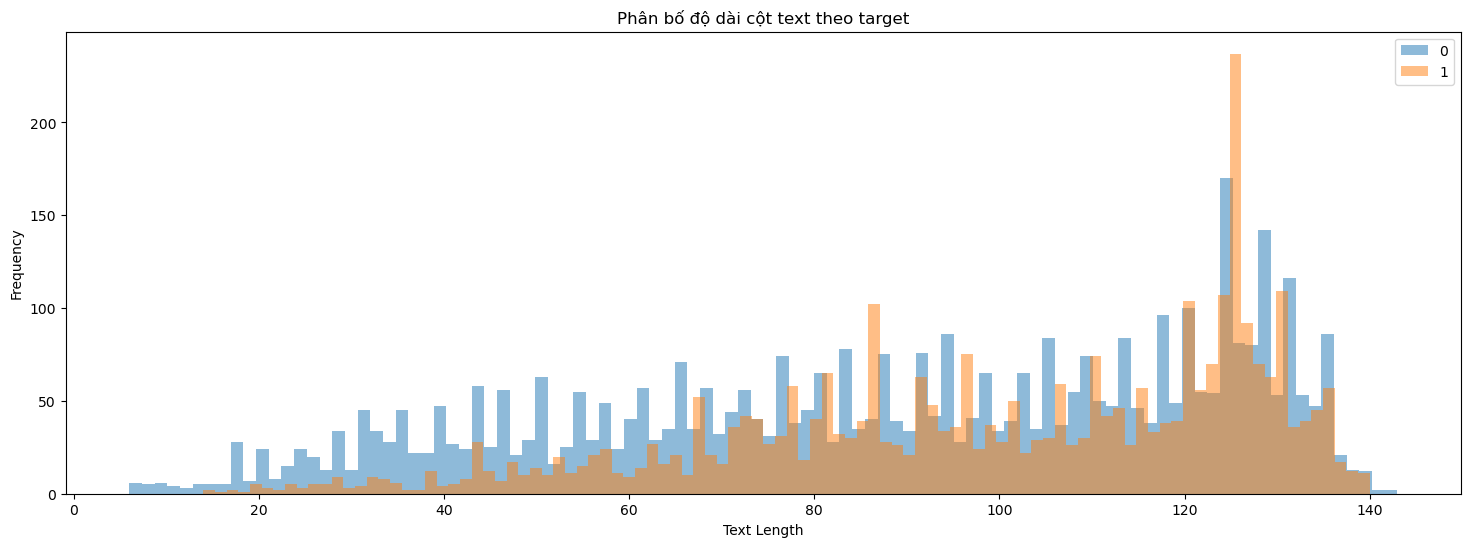

In [158]:
df_with_text_length = train_df.copy()
df_with_text_length['text_length'] = df_with_text_length['text'].apply(len)


# Tách dữ liệu cho mỗi target
target_0 = df_with_text_length[df_with_text_length['target'] == 0]['text_length']
target_1 = df_with_text_length[df_with_text_length['target'] == 1]['text_length']

# Vẽ histogram
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(target_0, bins=100, alpha=0.5, label='0')
plt.hist(target_1, bins=100, alpha=0.5, label='1')

# Đặt tên trục và tiêu đề
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("Phân bố độ dài cột text theo target")

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

## CHỉnh màu cho histogram

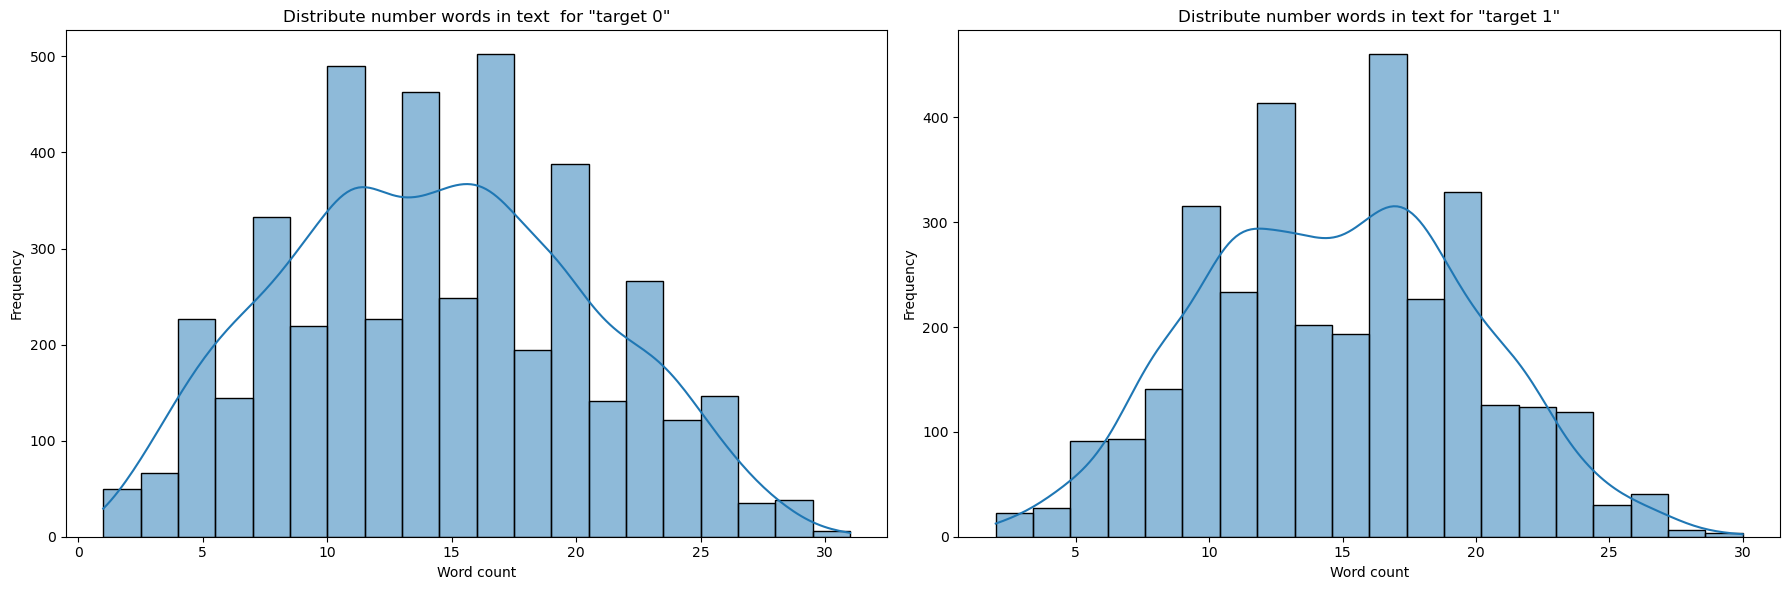

In [159]:

df_with_word_count = train_df.copy()
df_with_word_count['word_count'] = train_df['text'].str.split().map(lambda x: len(x))


fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 0], x='word_count', bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribute number words in text  for "target 0"')
axes[0].set_xlabel('Word count')
axes[0].set_ylabel('Frequency')

sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 1], x='word_count', bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribute number words in text for "target 1"')
axes[1].set_xlabel('Word count')
axes[1].set_ylabel('Frequency')

# Hiển thị biểu đồ
plt.tight_layout()

plt.show()

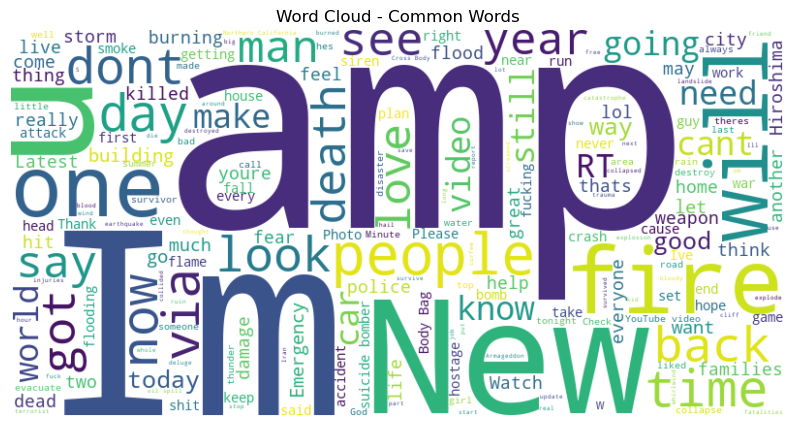

In [160]:
# Tạo một chuỗi từ tất cả các câu trong cột "text"
text_combined = ' '.join(train_df['text'])

# Khởi tạo đối tượng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Vẽ word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Common Words')
plt.show()

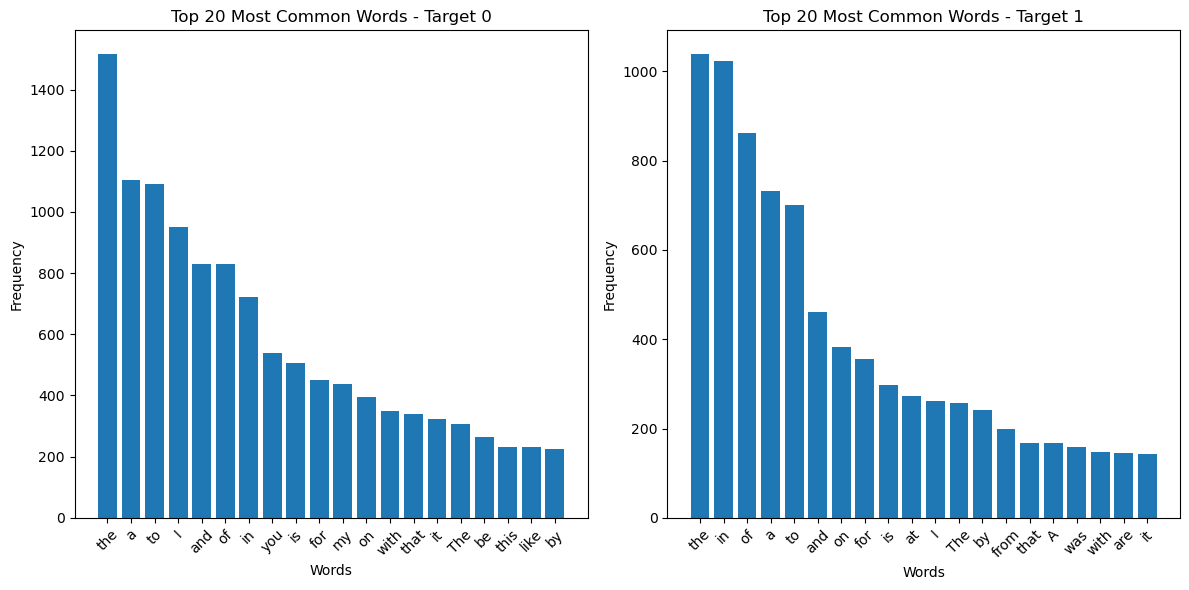

In [161]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0
words_0 = train_df['text'][train_df["target"] == 0].str.split()
all_words_0 = [word for sublist in words_0 for word in sublist]
word_counts_0 = Counter(all_words_0)
top_20_words_0 = word_counts_0.most_common(20)
word_list_0, word_count_0 = zip(*top_20_words_0)

# Tách các từ trong cột "text" với target = 1
words_1 = train_df['text'][train_df["target"] == 1].str.split()
all_words_1 = [word for sublist in words_1 for word in sublist]
word_counts_1 = Counter(all_words_1)
top_20_words_1 = word_counts_1.most_common(20)
word_list_1, word_count_1 = zip(*top_20_words_1)

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].bar(word_list_0, word_count_0)
axes[0].set_title('Top 20 Most Common Words - Target 0')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].bar(word_list_1, word_count_1)
axes[1].set_title('Top 20 Most Common Words - Target 1')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
